# Conditional Variational Autoencoder - MNIST & TensorFlow2

- [Learning Structured Output Representation using Deep Conditional Generative Models](https://papers.nips.cc/paper/2015/hash/8d55a249e6baa5c06772297520da2051-Abstract.html) by Kihyuk Sohn et al.

- [YouTube video](https://www.youtube.com/watch?app=desktop&v=W4peyiOaEFU)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-02-17 17:25:18.966904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 17:25:18.987882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 17:25:18.987973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 17:25:18.988573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

In [6]:
# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (28, 28, 1)


In [9]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 30

In [10]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [11]:
# By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks
# work best when each input is inside the range –1 to 1, so we need to divide by 255.

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [12]:
# Convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [13]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [14]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (60000, 784), y_train.shape: (60000, 10)
X_test.shape: (10000, 784), y_test.shape: (10000, 10)


In [ ]:
# X_train_concat = tf.concat(values = [X_train, y_train], axis = 1)
# X_test_concat = tf.concat(values = [X_test, y_test], axis = 1)

In [ ]:
# print("\nDimensions of training and testing concatenated sets are:")
# print(f"X_train_concat.shape: {X_train_concat.shape} & X_test_concat.shape: {X_test_concat.shape}")
# Dimensions of training and testing concatenated sets are:
# X_train_concat.shape: (60000, 794) & X_test_concat.shape: (10000, 794)

In [ ]:
# del X_train_concat, X_test_concat

In [19]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [16]:
# Create TF datasets-
# train_dataset = tf.data.Dataset.from_tensor_slices(X_train_concat).shuffle(60000).batch(128)
# test_dataset = tf.data.Dataset.from_tensor_slices(X_test_concat).shuffle(10000).batch(128)

# Needed by 'tf.GradientTape()' API for custom training and testing code.

In [20]:
train_dataset = train_dataset.shuffle(buffer_size = 60000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)
test_dataset = test_dataset.batch(batch_size = batch_size, drop_remainder = False)

In [21]:
# Sanity check-
x, y = next(iter(train_dataset))

In [22]:
x.shape, y.shape

(TensorShape([64, 784]), TensorShape([64, 10]))

In [23]:
y[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)>

In [24]:
del x, y

### Define _Variational Autoencoder_ architecture using dense layers

In [25]:
class Encoder(Model):
    def __init__(self, latent_space = 3):
        super(Encoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(
            units = 300, activation = None
        )
        self.dense2 = Dense(
            units = 100, activation = None
        )
        self.encoder_output = Dense(
            units = self.latent_space, activation = None
        )
        
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = tf.keras.activations.relu(self.encoder_output(x))
        
        return x
        

In [26]:
class Decoder(Model):
    def __init__(self, latent_space = 3):
        super(Decoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(
            units = 100, activation = None
        )
        self.dense2 = Dense(
            units = 300, activation = None
        )
        self.decoder_output = Dense(
            units = 784, activation = None
        )
    
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        x = tf.keras.activations.relu(self.dense2(x))
        x = self.decoder_output(x)
        
        return x
    

In [ ]:
# encoder = Encoder(latent_space = 3)

In [ ]:
# decoder = Decoder(latent_space = 3)

In [ ]:
# x, y = next(iter(train_dataset))

In [ ]:
# x.shape, y.shape
# (TensorShape([64, 784]), TensorShape([64, 10]))

In [ ]:
# tf.concat(values = [x, y], axis = 1).shape
# TensorShape([64, 794])

In [ ]:
# x_enc = encoder(tf.concat(values = [x, y], axis = 1))

In [ ]:
# x_enc.shape
# TensorShape([64, 3])

In [ ]:
# x_dec = decoder(tf.concat(values = [x_enc, y], axis = 1))

In [ ]:
# x_dec.shape, x.shape, x_enc.shape
# (TensorShape([64, 784]), TensorShape([64, 784]), TensorShape([64, 3]))

In [ ]:
# del x, x_enc, x_dec, encoder, decoder

In [27]:
class VAE(Model):
    def __init__(self, latent_space = 3):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        
        self.encoder = Encoder(latent_space = self.latent_space)
        self.decoder = Decoder(latent_space = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mean, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mean.shape, mean = 0.0,
            stddev = 1.0, dtype = tf.float32
        )
        return (eps * tf.exp(logvar * 0.5) + mean)
        
    
    def call(self, x, y):
        # y = x[:, 784:]
        # x = self.encoder(x)
        x = self.encoder(tf.concat(values = [x, y], axis = 1))
        # print(f"x.shape: {x.shape}, y.shape: {y.shape}")
        # x.shape: (batch_size, 3), y.shape: (batch_size, 10)
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 3), log_var.shape: (batch_size, 3) & z.shape: (batch_size, 3)
        '''
        # z = tf.concat(values = [z, y], axis = 1)
        # print(f"After concat z.shape: {z.shape}")
        x = tf.keras.activations.sigmoid(self.decoder(tf.concat(values = [z, y], axis = 1)))
        # x = tf.keras.activations.sigmoid(self.decoder(z))
        return x, mu, log_var
        

In [28]:
# Initialize VAE model-
model = VAE(latent_space = 3)

In [29]:
# Sanity check-
x, y = next(iter(train_dataset))

In [30]:
x.shape, y.shape

(TensorShape([64, 784]), TensorShape([64, 10]))

In [31]:
x_recon, mu, log_var = model(x, y)

2022-02-17 17:26:42.256279: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [32]:
x_recon.shape, x.shape 

(TensorShape([64, 784]), TensorShape([64, 784]))

In [33]:
mu.shape, log_var.shape

(TensorShape([64, 3]), TensorShape([64, 3]))

In [34]:
mu.numpy().mean(), mu.numpy().std()

(0.00077247503, 0.12035693)

In [35]:
log_var.numpy().mean(), log_var.numpy().std()

(-0.015541531, 0.08232848)

In [36]:
del x, y, x_recon, mu, log_var

In [37]:
# Get model summary-
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  268903    
                                                                 
 decoder (Decoder)           multiple                  267684    
                                                                 
 dense_6 (Dense)             multiple                  12        
                                                                 
 dense_7 (Dense)             multiple                  12        
                                                                 
Total params: 536,611
Trainable params: 536,611
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Count layer-wise number of trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (794, 300) has 238199 parameters
layer: (300,) has 0 parameters
layer: (300, 100) has 30000 parameters
layer: (100,) has 0 parameters
layer: (100, 3) has 300 parameters
layer: (3,) has 0 parameters
layer: (13, 100) has 1300 parameters
layer: (100,) has 0 parameters
layer: (100, 300) has 30000 parameters
layer: (300,) has 0 parameters
layer: (300, 784) has 235200 parameters
layer: (784,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters


In [39]:
print(f"VAE has {tot_params} trainable parameters")

VAE has 535017 trainable parameters


In [40]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [41]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1, beta = 1):
    
    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            # tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            tf.keras.losses.mean_squared_error(data, reconstruction),
            # axis = (1, 2)
            )
        )
    
    # KL-divergence loss-    
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))

    total_loss = (recon_loss * alpha) + (kl_loss * beta)
    
    return total_loss, recon_loss, kl_loss
    

In [ ]:
"""
def compute_loss(data, reconstruction, mu, log_var, alpha = 1, beta = 1):
    
    # Reconstruction loss-
    recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))
    
    # KL-divergence loss-
    kl_loss = -0.5 * (1 + log_var - K.square(mu) - K.exp(log_var))
    # kl_loss = K.sum(kl_loss, axis = -1)
    # kl_loss = K.mean(kl_loss)
    kl_loss = K.mean(K.sum(kl_loss, axis = -1))
    
    total_loss = (recon_loss * alpha) + kl_loss
    
    return total_loss, recon_loss, kl_loss
"""

In [ ]:
'''
total_loss, recon_loss, kl_loss = compute_loss(
    data = X, reconstruction = X_recon,
    mu = mu, log_var = log_var,
    alpha = 1, beta = 1
)
'''

In [ ]:
# total_loss
# <tf.Tensor: shape=(), dtype=float32, numpy=1.0787445>

In [64]:
@tf.function
def train_one_step(model, optimizer, x, y, alpha, beta):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        X_recon, mu, log_var = model(x, y)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = x, reconstruction = X_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads), len(grads)
    # (list, 20)
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


In [65]:
@tf.function
def test_step(model, optimizer, x, y, alpha, beta):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    X_recon, mu, log_var = model(x, y)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = x, reconstruction = X_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )
    
    return total_loss, recon_loss, kl_loss


In [ ]:
'''
total_loss = train_one_step(
    model = model, optimizer = optimizer,
    data = X, alpha = 1,
    beta = 1
)
'''

In [ ]:
# total_loss
# <tf.Tensor: shape=(), dtype=float32, numpy=0.23313756>

In [66]:
# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [67]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 1

In [68]:
beta = 1

In [69]:
print(f"Conditional VAE will be trained for {num_epochs} epochs")

Conditional VAE will be trained for 30 epochs


In [70]:
for epoch in range(1, num_epochs + 1):
    
    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0
    
    for x, y in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            x = x, y = y,
            alpha = alpha, beta = beta
        )
        
        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()
    
    for x, y in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            x = x, y = y,
            alpha = alpha, beta = beta
        )
        
        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()
    
    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }
    
    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )
    

epoch = 1; total train loss = 5059.9284, train recon loss = 5037.8071, train kl loss = 22.1213; total val loss = 630.9005, val recon loss = 630.8390 & val kl loss = 0.0615
epoch = 2; total train loss = 3533.9863, train recon loss = 3533.7802, train kl loss = 0.2062; total val loss = 554.4937, val recon loss = 554.4602 & val kl loss = 0.0335
epoch = 3; total train loss = 3285.5968, train recon loss = 3285.3708, train kl loss = 0.2260; total val loss = 538.7989, val recon loss = 538.7647 & val kl loss = 0.0342
epoch = 4; total train loss = 3237.8277, train recon loss = 3237.6700, train kl loss = 0.1577; total val loss = 534.0060, val recon loss = 533.9882 & val kl loss = 0.0178
epoch = 5; total train loss = 3223.1565, train recon loss = 3223.0766, train kl loss = 0.0799; total val loss = 532.3537, val recon loss = 532.3447 & val kl loss = 0.0091
epoch = 6; total train loss = 3215.7607, train recon loss = 3215.7194, train kl loss = 0.0414; total val loss = 531.2437, val recon loss = 531.2

In [71]:
# Sanity check for Python3 dicts containing training metrics-
training_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [72]:
val_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [73]:
training_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [74]:
val_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [75]:
# Save trained model-
model.save_weights("Conditional_VAE_MNIST_trained.h5", overwrite = True)

### Visualize training metrics

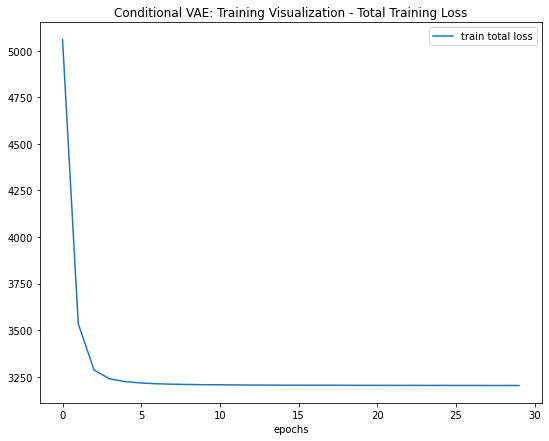

In [76]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("Conditional VAE: Training Visualization - Total Training Loss")
plt.show()

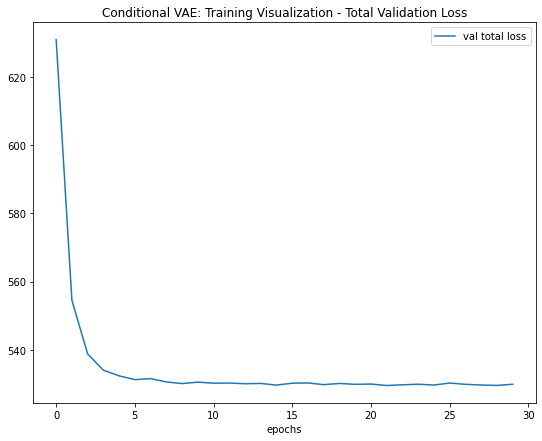

In [77]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['total_loss'] for e in val_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("Conditional VAE: Training Visualization - Total Validation Loss")
plt.show()

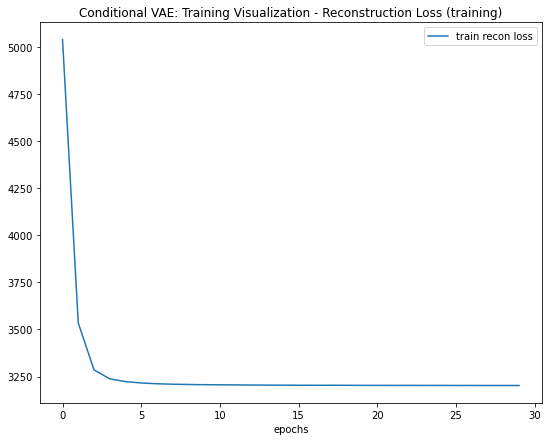

In [78]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("Conditional VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

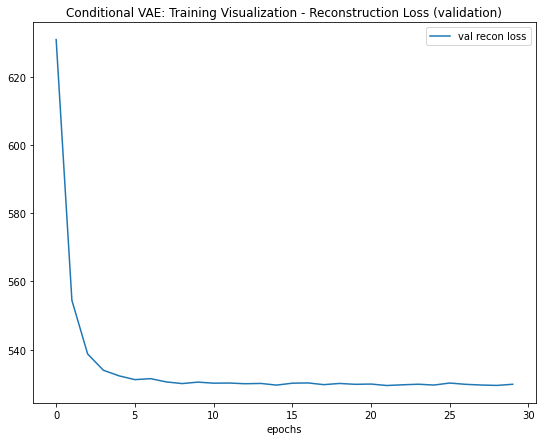

In [79]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['recon_loss'] for e in val_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("Conditional VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

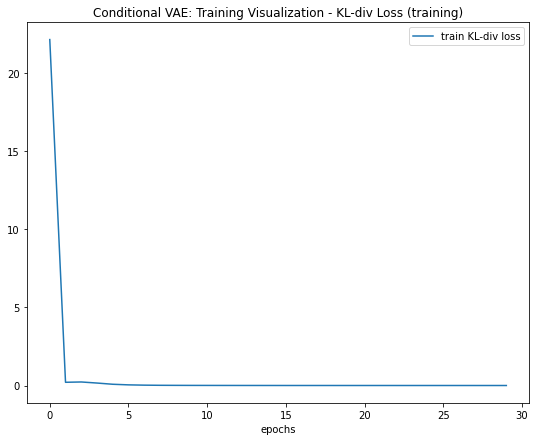

In [80]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("Conditional VAE: Training Visualization - KL-div Loss (training)")
plt.show()

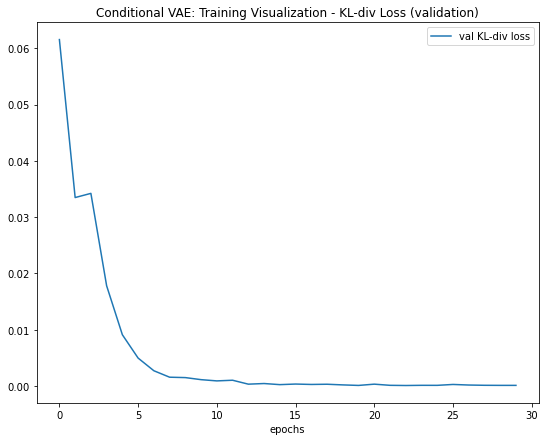

In [81]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['kl_loss'] for e in val_metrics.keys()], label = 'val KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("Conditional VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

### Visualize _reconstructions_ using trained VAE model

In [115]:
x, y = next(iter(train_dataset))

In [116]:
x.shape, y.shape

(TensorShape([64, 784]), TensorShape([64, 10]))

In [117]:
# Get reconstructions, mean & log-variance from trained model-
x_recon, mu, log_var = model(x, y)

In [118]:
# Sanity check-
x.shape, x_recon.shape

(TensorShape([64, 784]), TensorShape([64, 784]))

In [119]:
x_recon = tf.reshape(
    tensor = x_recon,
    shape = ((x_recon.shape[0], 28, 28)),
    name = None
)

In [120]:
x_recon.numpy().shape

(64, 28, 28)

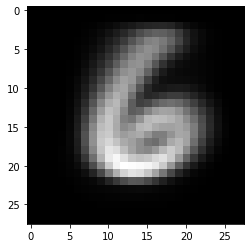

In [121]:
# Visualize a single digit-
plt.imshow(x_recon[20], cmap = plt.get_cmap('gray'))
plt.show()

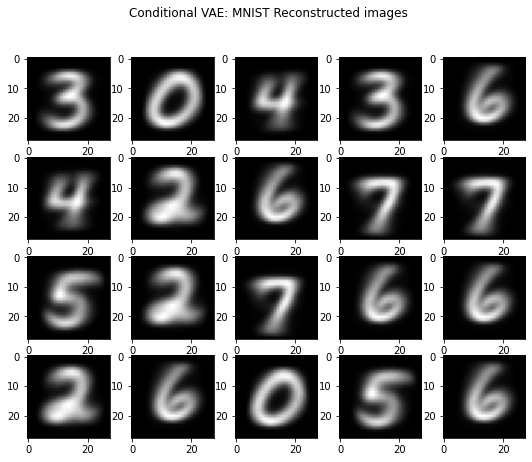

In [122]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_recon[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("Conditional VAE: MNIST Reconstructed images")
plt.show()

### Generate MNIST reconstructed images for digit _5_:

In [123]:
mu.shape, log_var.shape

(TensorShape([64, 3]), TensorShape([64, 3]))

In [125]:
mu[:20].shape, log_var[:20].shape

(TensorShape([20, 3]), TensorShape([20, 3]))

In [128]:
eps = tf.random.normal(
    shape = mu.shape, mean = 0.0,
    stddev = 1.0, dtype = tf.float32
)

In [131]:
z = (eps * tf.exp(log_var * 0.5) + mu)

In [132]:
z.shape, eps.shape

(TensorShape([64, 3]), TensorShape([64, 3]))

In [161]:
z[:5, :].shape

TensorShape([5, 3])

In [181]:
# Condition reconstructions for MNIST digit '9'-
y = tf.constant(
    [
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]
    ]
) 

In [182]:
y.shape

TensorShape([5, 10])

In [183]:
z_final = tf.concat(values = [z[:5, :], y], axis = 1)

In [184]:
# Sanity check-
z_final.shape, mu[:5].shape, log_var[:5].shape

(TensorShape([5, 13]), TensorShape([5, 3]), TensorShape([5, 3]))

In [185]:
# Get reconstructions using trained decoder-
img_recon = model.decoder(z_final)

In [186]:
img_recon.shape

TensorShape([5, 784])

In [187]:
img_recon = img_recon.numpy().reshape(img_recon.shape[0], 28, 28)

In [188]:
img_recon.shape

(5, 28, 28)

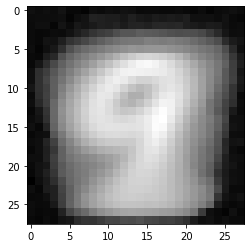

In [189]:
# Visualize a single digit-
plt.imshow(img_recon[0], cmap = plt.get_cmap('gray'))
plt.show()

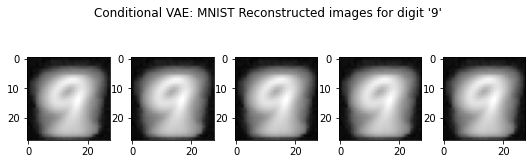

In [190]:
# Visualize 20 reconstruced images for MNIST digit '5'-
plt.figure(figsize = (9, 7))
for i in range(5):
    # 1 row & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(img_recon[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("Conditional VAE: MNIST Reconstructed images for digit '9'")
plt.show()

In [202]:
# Condition reconstructions for MNIST digit '1-
y = tf.constant(
    [
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]
    ]
) 

In [203]:
y.shape

TensorShape([5, 10])

In [204]:
z_final = tf.concat(values = [z[:5, :], y], axis = 1)

In [205]:
# Sanity check-
z_final.shape, mu[:5].shape, log_var[:5].shape

(TensorShape([5, 13]), TensorShape([5, 3]), TensorShape([5, 3]))

In [206]:
# Get reconstructions using trained decoder-
img_recon = model.decoder(z_final)

In [207]:
img_recon.shape

TensorShape([5, 784])

In [208]:
img_recon = img_recon.numpy().reshape(img_recon.shape[0], 28, 28)

In [209]:
img_recon.shape

(5, 28, 28)

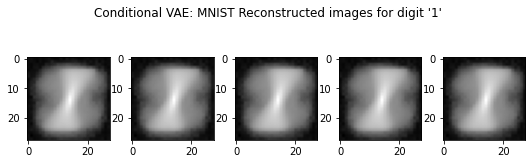

In [210]:
# Visualize 20 reconstruced images for MNIST digit '2'-
plt.figure(figsize = (9, 7))
for i in range(5):
    # 1 row & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(img_recon[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("Conditional VAE: MNIST Reconstructed images for digit '1'")
plt.show()

In [192]:
# Condition reconstructions for MNIST digit '2'-
y = tf.constant(
    [
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]
    ]
) 

In [193]:
y.shape

TensorShape([5, 10])

In [194]:
z_final = tf.concat(values = [z[:5, :], y], axis = 1)

In [195]:
# Sanity check-
z_final.shape, mu[:5].shape, log_var[:5].shape

(TensorShape([5, 13]), TensorShape([5, 3]), TensorShape([5, 3]))

In [196]:
# Get reconstructions using trained decoder-
img_recon = model.decoder(z_final)

In [197]:
img_recon.shape

TensorShape([5, 784])

In [198]:
img_recon = img_recon.numpy().reshape(img_recon.shape[0], 28, 28)

In [199]:
img_recon.shape

(5, 28, 28)

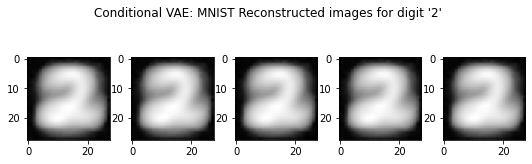

In [201]:
# Visualize 20 reconstruced images for MNIST digit '2'-
plt.figure(figsize = (9, 7))
for i in range(5):
    # 1 row & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(img_recon[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("Conditional VAE: MNIST Reconstructed images for digit '2'")
plt.show()

#### Check _mu_ and _log_var_ latent space vectors:

In [211]:
mu.shape, log_var.shape

(TensorShape([64, 3]), TensorShape([64, 3]))

In [212]:
print(f"mu: mean = {mu.numpy().mean():.4f} & "
f"std dev = {mu.numpy().std():.4f}")

mu: mean = -0.0003 & std dev = 0.0004


In [213]:
print(f"log var: mean = {log_var.numpy().mean():4f} &"
f" std dev = {log_var.numpy().std():.4f}")

log var: mean = -0.000576 & std dev = 0.0001


### Visualize _mean_ and _log-variance_ of _latent space_ using trained VAE model

In [ ]:
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    # color = y_train[:1000]
    )
fig.show()

In [ ]:
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    # color = y_train[:1000]
    )
fig.show()

### Visualize _latent space_ of train & test datasets

In [193]:
X_train_encoded = model.encoder(X_train_concat)
X_test_encoded = model.encoder(X_test_concat)

In [194]:
X_train_concat.shape, X_train_encoded.shape

(TensorShape([60000, 794]), TensorShape([60000, 3]))

In [195]:
X_test_concat.shape, X_test_encoded.shape

(TensorShape([10000, 794]), TensorShape([10000, 3]))

In [ ]:
fig = px.scatter_3d(
    x = X_train_encoded[:, 0], y = X_train_encoded[:, 1],
    z = X_train_encoded[:, 2],
    # color = y_train
)
fig.show()

In [ ]:
fig = px.scatter_3d(
    x = X_test_encoded[:, 0], y = X_test_encoded[:, 1],
    z = X_test_encoded[:, 2],
    # color = y_test
)
fig.show()

In [198]:
del X_train_encoded, X_test_encoded